In [5]:
import numpy as np
import argparse
import time
import os
import sys
import pickle
from itertools import chain
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from datasets import inputs, sf_inputs_discrete
from sr_model.models.models import AnalyticSR, STDP_SR, OjaRNN, Linear
import configs
from eval import eval

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/Users/chingfang/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [345]:
one_hot = True
model = 'sr' # Choices: 'sr', 'oja', 'sf'
gamma = 0.4
lr = 1E-3

In [346]:
num_steps = 3000
num_states = 20
attractor_center = 8
attractor_scale = 10
attractor_width = 2

if one_hot:
    dset = inputs.Sim1DFeeder(
        num_steps=num_steps, left_right_stay_prob=[1, 1, 1],
        num_states=num_states,
        attractor_center=attractor_center,
        attractor_scale=attractor_scale,
        attractor_width=attractor_width
        )
else:
    sprs = 0.05
    sig = 2.0
    feature_maker_kwargs = {                                     
        'feature_dim': num_states,
        'feature_type': 'correlated_distributed',
        'feature_vals_p': [1-sprs, sprs], 'feature_vals': None,
        'spatial_sigma': sig
        }
    dset = sf_inputs_discrete.Sim1DFeeder(
        num_steps=num_steps, left_right_stay_prob=[5, 1, 1],
        num_states=num_states,
        attractor_center=attractor_center,
        attractor_scale=attractor_scale,
        attractor_width=attractor_width,
        feature_maker_kwargs=feature_maker_kwargs
        )

In [347]:
if model == 'sr':
    save_path = '../trained_models/baseline/'
    model_path = save_path + 'model.pt'
    net_configs_path = save_path + 'net_configs.p'
    with open(net_configs_path, 'rb') as f:
        net_configs = pickle.load(f)
    net_configs.pop('num_states')
    net = STDP_SR(num_states=num_states, **net_configs)
    net.load_state_dict(torch.load(model_path))
elif model == 'oja':
    net = OjaRNN(num_states=num_states, gamma=gamma, ca3_kwargs={'lr':lr})
elif model == 'sf':
    ca3_kwargs = {
        'use_dynamic_lr': False, 'parameterize': False,
        'lr': lr
        }
    net = AnalyticSR(
        num_states=num_states, gamma=gamma, ca3_kwargs=ca3_kwargs
        )
elif model == 'sf-parameterized':
    save_path = '/Volumes/aronov-locker/Ching/03_td_discrete_corr/'
    save_path += f'sparsity{sprs}/sigma{sig}/'
    save_path += '0.75/rnn/0/model.pt'
    ca3_kwargs = {
        'use_dynamic_lr': False, 'parameterize': True,
        'output_params':{'num_iterations': 20,'nonlinearity': 'clamp'}
        }
    net = AnalyticSR(
        num_states=num_states, gamma=0.7, ca3_kwargs=ca3_kwargs
        )
    net.load_state_dict(torch.load(save_path))

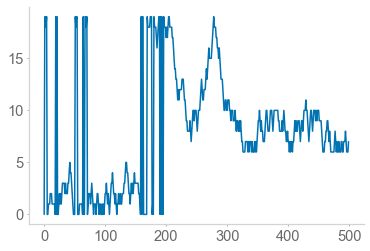

In [348]:
plt.figure()
window = dset.ys[:500]
plt.plot(np.arange(window.size), window)
plt.show()

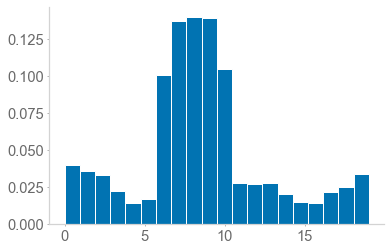

In [349]:
plt.figure()
plt.hist(
    dset.ys, weights=[1/dset.ys.size]*dset.ys.size,
    bins=num_states
    )
plt.show()

In [350]:
# Set up dataset
dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
dg_modes = torch.from_numpy(dset.dg_modes.T).float().to(device).unsqueeze(1)

# Early fields

In [351]:
ff_M = []
end_idx = 500
outputs = net(dg_inputs[:end_idx], dg_modes[:end_idx], reset=True, gamma=gamma)
for neur in range(num_states):
    ff = []
    for state in range(num_states):
        ff.append(np.mean(
            outputs[1][dset.ys[:end_idx]==state,neur].detach().numpy()
            ))
    ff_M.append(ff)

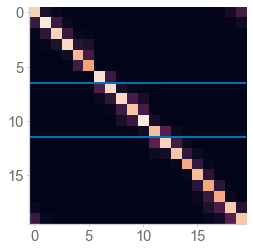

In [352]:
plt.figure()
ff_M = np.array(ff_M)
init_sort = np.argsort(np.argmax(ff_M,axis=1)).astype(int)
plt.imshow(ff_M[init_sort,:])
plt.axhline(attractor_center - attractor_width + 0.5, linewidth=2)
plt.axhline(attractor_center + attractor_width + 1.5, linewidth=2)
plt.show()

In [353]:
if one_hot:
    M = net.get_M(gamma=0.95).detach().numpy().squeeze()

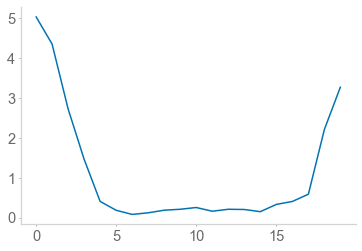

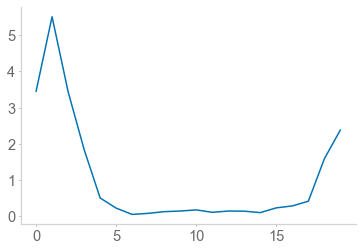

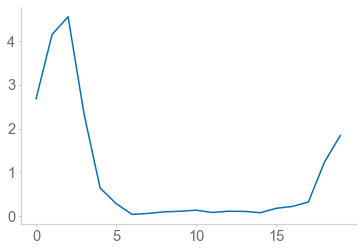

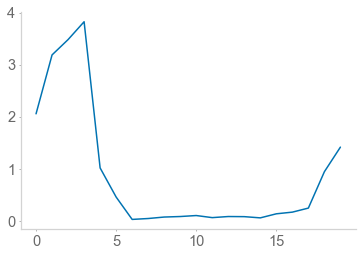

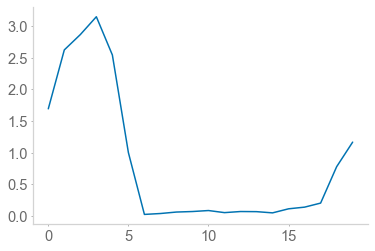

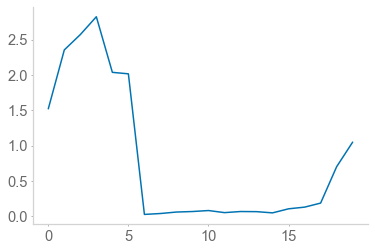

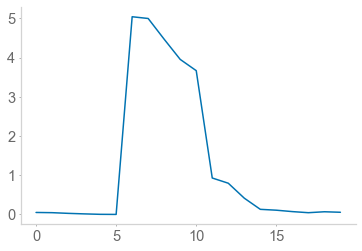

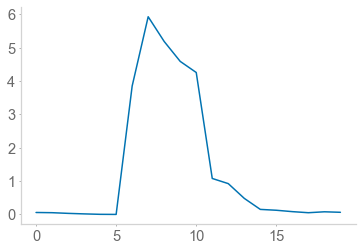

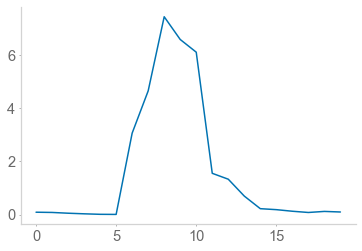

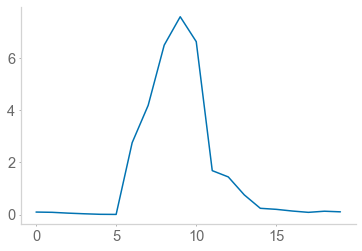

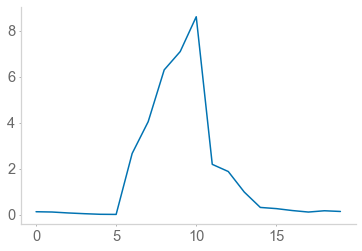

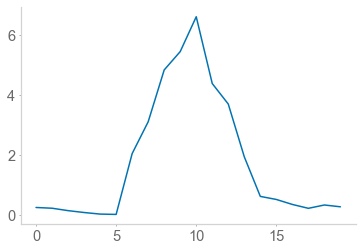

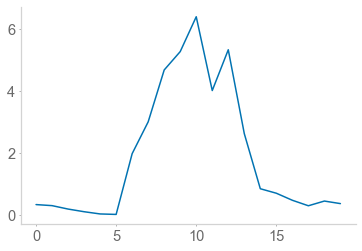

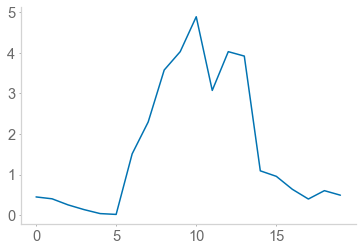

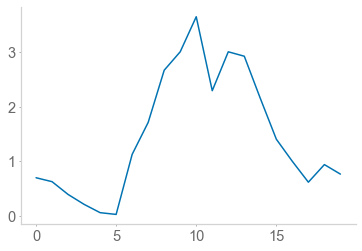

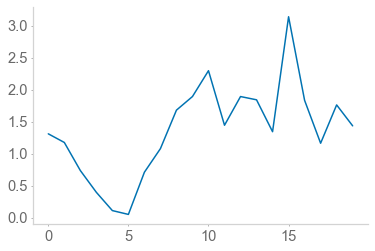

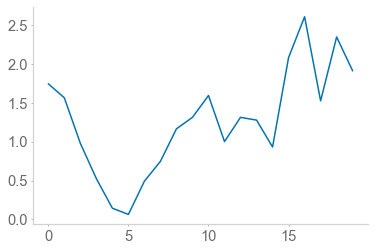

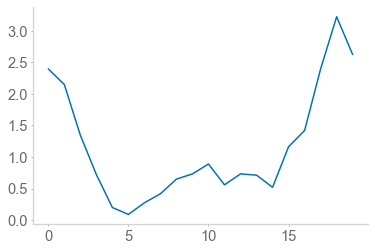

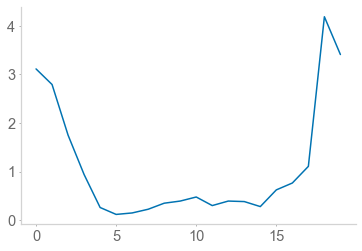

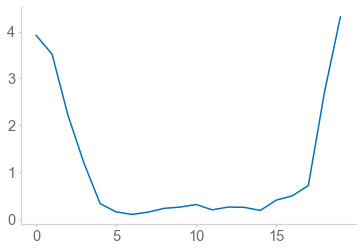

In [354]:
if one_hot:
    for i in range(num_states):
        plt.figure()
        plt.plot(M[i].tolist()*1)
        plt.show()

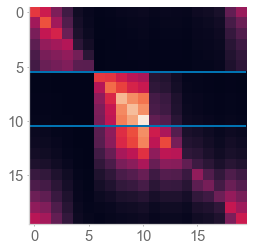

In [356]:
if one_hot:
    plt.figure()
    plt.imshow(M)
    plt.axhline(attractor_center - attractor_width - 0.5, linewidth=2)
    plt.axhline(attractor_center + attractor_width + 0.5, linewidth=2)
    plt.show()

# Final fields

In [357]:
ff_M = []
outputs = net(dg_inputs, dg_modes, reset=True, gamma=gamma)
for neur in range(num_states):
    ff = []
    for state in range(num_states):
        ff.append(np.mean(
            outputs[1][dset.ys==state,neur].detach().numpy()
            ))
    ff_M.append(ff)

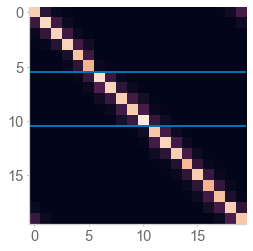

In [358]:
plt.figure()
ff_M = np.array(ff_M)
plt.imshow(ff_M[init_sort,:])
plt.axhline(attractor_center - attractor_width - 0.5, linewidth=2)
plt.axhline(attractor_center + attractor_width + 0.5, linewidth=2)
plt.show()

In [359]:
if one_hot:
    M = net.get_M(gamma=0.95).detach().numpy().squeeze()

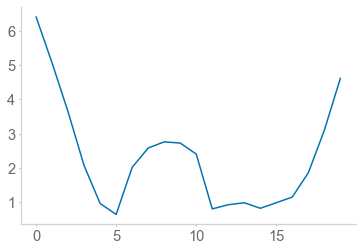

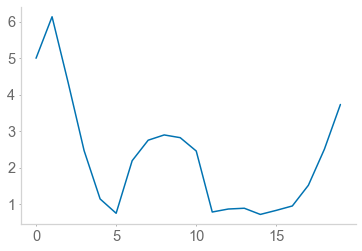

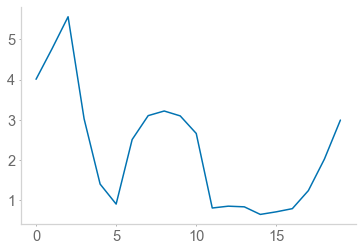

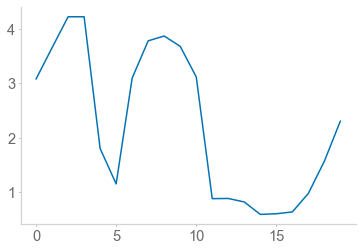

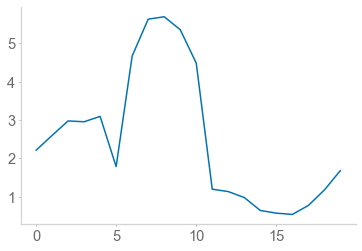

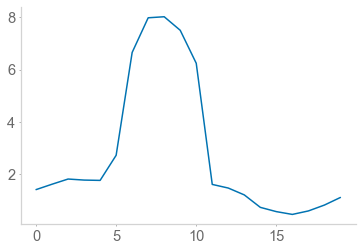

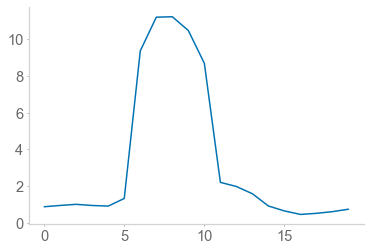

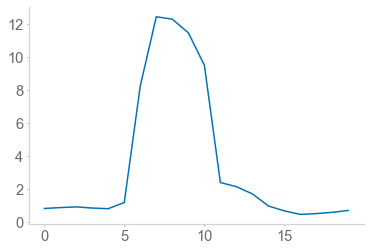

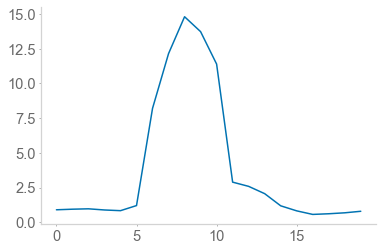

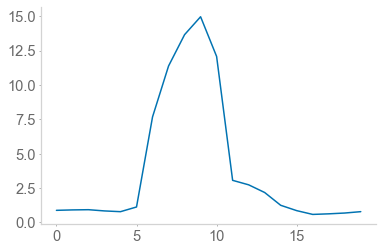

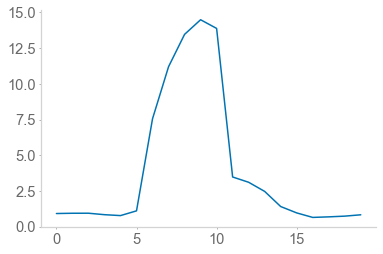

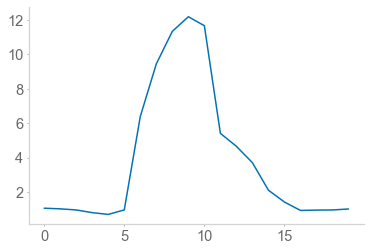

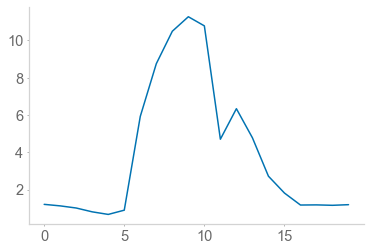

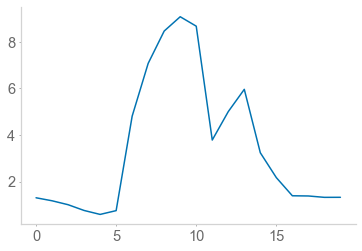

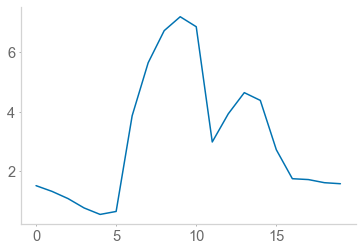

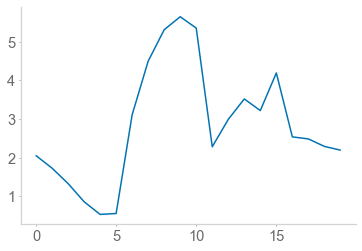

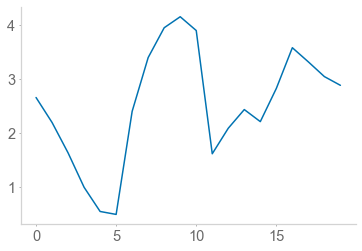

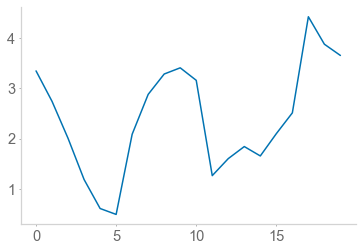

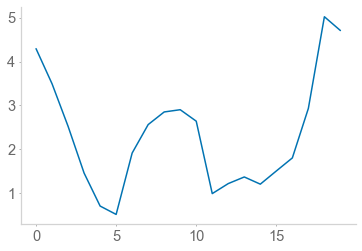

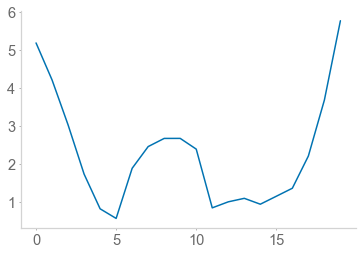

In [360]:
if one_hot:
    for i in range(num_states):
        plt.figure()
        plt.plot(M[i].tolist()*1)
        plt.show()

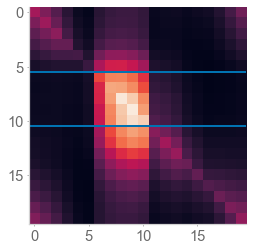

In [361]:
if one_hot:
    plt.figure()
    plt.imshow(M)
    plt.axhline(attractor_center - attractor_width - 0.5, linewidth=2)
    plt.axhline(attractor_center + attractor_width + 0.5, linewidth=2)
    plt.show()

# Original Feature Map

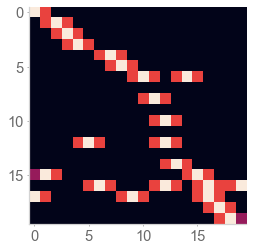

In [146]:
plt.figure()
plt.imshow(dset.feature_maker.feature_map[init_sort])
plt.show()

# Linear Regression

In [63]:
from sklearn.linear_model import LinearRegression

X = outputs[1].detach().numpy()
y = dset.ys

reg = LinearRegression().fit(X, y)

reg.score(X, y)

0.9300653631307296